In [3]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import hough_line, hough_line_peaks
from PIL import Image 

import os
from skimage import morphology
import cv2
import skimage as sk

In [4]:
# General to use

def show(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 
    
#########################################################################################################
    
def binarize(img, block_size=35):
    t = sk.filters.threshold_local(img, block_size, offset=10)
#     t = sk.filters.threshold_otsu(img)
    img_b = img < t
    return img_b


def runs_of_ones_array(bits):
    # print(np.invert(bits))
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], bits, [0]))
    # get 1 at run starts and -1 at run ends
    difs = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends, = np.where(difs < 0)
    return run_ends - run_starts


def verticalRunLength(img):
    # white runs
    arr = []
    for i in range(0, img.shape[1]):
        a = runs_of_ones_array(img[:, i])
        for x in a:
            arr.append(x)
    # print(arr)
    counts = np.bincount(arr)
    staff_height = np.argmax(counts)
    # black runs
    arr = []
    for i in range(0, img.shape[1]):
        a = runs_of_ones_array(np.invert(img[:, i]))
        for x in a:
            arr.append(x)
    # print(arr)
    counts = np.bincount(arr)
    staff_space = np.argmax(counts)
    return staff_height, staff_space

#########################################################################################################

def extractCircleNotes(img, staff_height):
    newImg = np.copy(img)
    #################  We May Littilize Factors of the SE  #################
    se = np.ones(((staff_height+1)*2, (staff_height+1)*2))
    newImg = sk.morphology.binary_opening(newImg, se)
    return newImg

#########################################################################################################

def deskew(original_img, theta_range=(-np.pi, np.pi)):
    img = np.copy((original_img))
    # Canny
    imgCanny = sk.feature.canny(img, sigma=1.5)
    thresh = sk.filters.threshold_otsu(imgCanny)
    imgCanny = (imgCanny >= thresh)

    # Apply Hough Transform
    thetaL, thetaR = theta_range 
    angleSet = np.linspace(thetaL, thetaR, 2880)
    houghArr, theta, dis = sk.transform.hough_line(imgCanny, angleSet)

    flatIdx = np.argmax(houghArr)
    bestTheta = (flatIdx % theta.shape[0])
    bestTheta = angleSet[bestTheta]
    bestDis = np.int32(np.floor(flatIdx / theta.shape[0]))
    bestDis = dis[bestDis]

    # Rotate
    thetaRotateDeg = (bestTheta*180)/np.pi
    if thetaRotateDeg > 0:
        thetaRotateDeg = thetaRotateDeg - 90
    else:
        thetaRotateDeg = thetaRotateDeg + 90

    imgRotated = (sk.transform.rotate(img, thetaRotateDeg, resize=True, mode='constant', cval=1))
    return imgRotated

#########################################################################################################


In [119]:

def get_lines_rows(img, T_LEN):
    row_start_freq = np.zeros((1, img.shape[0]+5))[0]
    row_starts = []
    
    for i in range(0, img.shape[1]):
        arr = runs_of_ones_array(img[:, i])
        k = 0
        j = 0
        while j < img.shape[0]:
            if img[j][i] == True:
                if arr[k] <= T_LEN + 2 and arr[k] >= T_LEN - 2:
                    row_start_freq[j] += 1
                    j += arr[k]-1
                else:
                    j += arr[k]

                k += 1
            j += 1
    
    max_freq_row_start = 0
    for r in row_start_freq:
        max_freq_row_start = max(max_freq_row_start, r)
    
    for i in range(len(row_start_freq)):
        # Approximately, if the row "i" is frequently treated as a starting of staffs with this ratio
        # by the most frequnt starting row, then consider it as a starting row of staffs.
        if row_start_freq[i]/max_freq_row_start >= 0.12:
            row_starts.append(i)
    return [row_starts, row_start_freq, max_freq_row_start]

################################################################################################

def without_lines2(img, T_LEN):
    staff_rows_starts, row_start_freq, max_freq_row_start = get_lines_rows(img, T_LEN)
    is_here = np.zeros((1, img.shape[0] + 10))[0]
    for x in staff_rows_starts:
        is_here[x] = 1
    
    print(staff_rows_starts)
    
    newImg = np.zeros(img.shape)
    
    for i in range(0, img.shape[1]):
        arr = runs_of_ones_array(img[:, i])

        block_num = 0
        row = 0
        while row < img.shape[0]:
            if img[row][i] == True:
                
                found = False
                for idx in range(0, int(1.5*T_LEN)):
                    if row - idx >= 0 and row - idx < img.shape[0]: 
                        if is_here[row - idx]:# and row_start_freq[row] / max_freq_row_start >= 0.1:
                            found = True
                            jump = T_LEN
                            row += jump 
                            arr[block_num] -= jump

                            arr[block_num] = max(arr[block_num], 0)

                            if arr[block_num] > 0:
                                block_num -= 1
                            break
                
                if found == False:
                    for item in range(arr[block_num]):
                        if row >= img.shape[0]:
                            break
                        newImg[row][i] = True
                        row += 1
                        
                row -= 1
                block_num += 1
            row += 1
    return newImg
     

[59, 60, 80, 100, 120, 121, 140, 141]


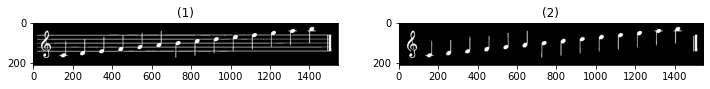

In [72]:
img = rgb2gray(io.imread('imgs/PublicTestCases/test-set-scanned/test-cases/04.PNG'))#[:, ]
# img = rgb2gray(io.imread('imgs/PublicTestCases/test-set-camera-captured/test-cases/24.jpg'))#[:800, :]

to_show = []

# Deskew
img = deskew(img)

# Binarization
img = img.astype(np.float64) / np.max(img)
img = 255 * img
img = img.astype(np.uint8)
img = binarize(img, 101)
img = np.array(img)

to_show.append(img)

# Get Staff-Depth, Staffs-Space
staff_height, staff_space = verticalRunLength(img)
T_LEN = staff_height

# Extract filled circles
img_1 = extractCircleNotes(img, staff_height)
img_1 = img_1 > 0

# Img without lines.
removed_staff = without_lines2(img, T_LEN)
removed_staff = removed_staff > 0
removed_staff = removed_staff | img_1

to_show.append(removed_staff)
show(to_show)


[45, 67, 68, 90, 112, 134, 135]


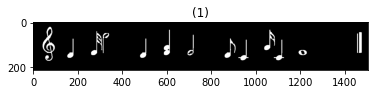

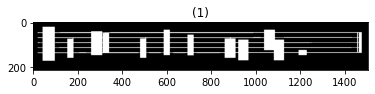

[41, 60, 78, 79, 97, 98, 116, 117, 218, 219, 237, 238, 256, 275, 294, 384, 385, 403, 422, 423, 441, 442, 460]


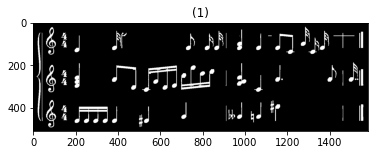

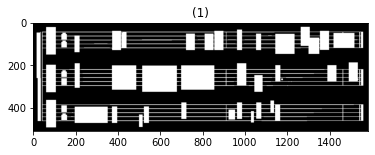

[56, 88, 120, 151, 152, 183, 184]


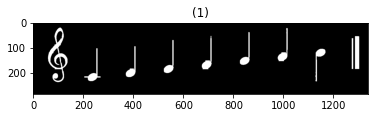

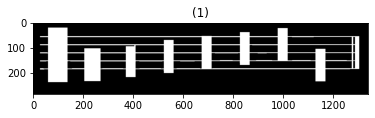

[59, 60, 80, 100, 120, 121, 140, 141]


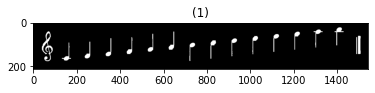

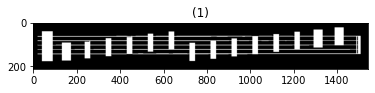

[64, 101, 138, 174, 175, 211, 212]


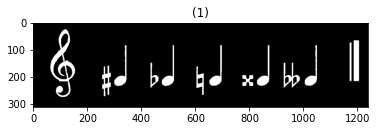

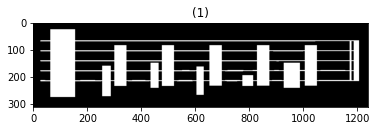

[67, 68, 111, 154, 197, 240, 241]


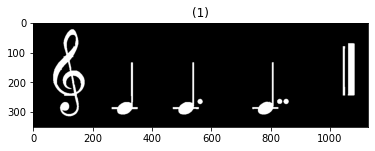

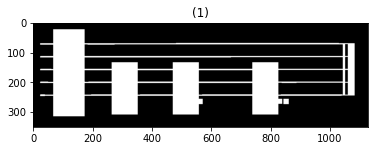

[78, 132, 187, 241, 242, 295, 296]


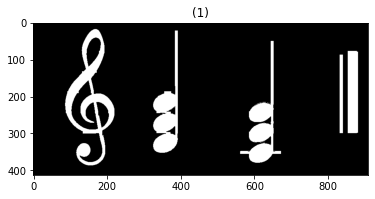

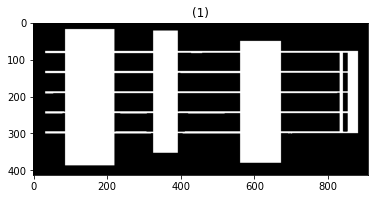

[91, 139, 140, 188, 189, 237, 238, 286]


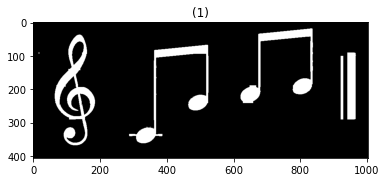

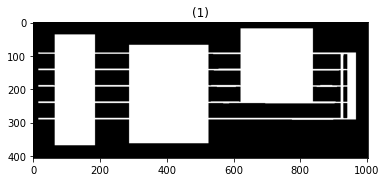

[75, 76, 117, 118, 160, 202, 244, 245]


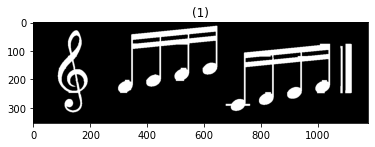

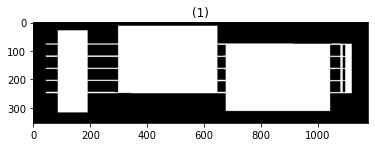

[72, 129, 187, 244, 245, 302]


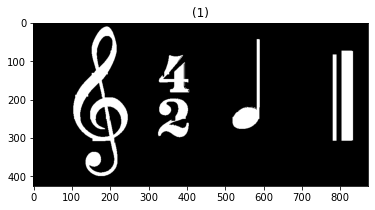

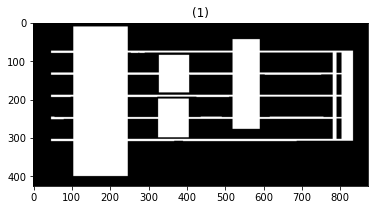

[15, 26, 27, 38, 49, 50, 61]


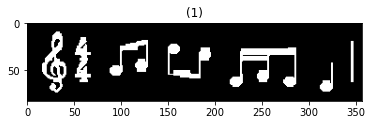

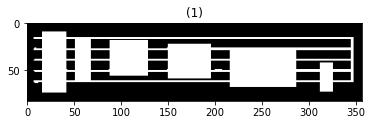

[16, 27, 28, 39, 50, 51, 62]


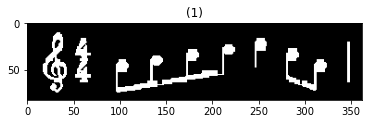

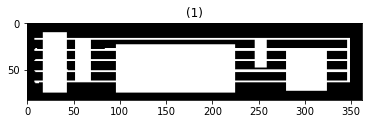

In [128]:
# Char Seg
def get_img_without_lines(img):
    staff_height, staff_space = verticalRunLength(img)
    T_LEN = staff_height
    ########
    img_1 = extractCircleNotes(img, staff_height)
    img_1 = img_1 > 0
    ##########
    #####
    removed_staff = without_lines2(img, T_LEN)
    removed_staff = removed_staff > 0
    removed_staff = removed_staff | img_1
    
    return removed_staff

def char_seg(org_img):
    img = np.copy(org_img)
    
    toshow = [img]
    
    labels = sk.measure.label(img, connectivity=1)
    lbl_num = np.max(labels[:, :])
    
    bounds = np.zeros((lbl_num+3, 4)) # [up, down, left, right]
    bounds[:, 0] = 99999999
    bounds[:, 2] = 99999999

    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j]:
                bounds[labels[ i, j ]][0] = min(bounds[labels[ i, j ]][0], i)
                bounds[labels[ i, j ]][1] = max(bounds[labels[ i, j ]][1], i)
                bounds[labels[ i, j ]][2] = min(bounds[labels[ i, j ]][2], j)
                bounds[labels[ i, j ]][3] = max(bounds[labels[ i, j ]][3], j)

    return bounds


folder = "imgs/PublicTestCases/test-set-scanned/test-cases/"
items = os.listdir(folder)
for i in items:
    img = rgb2gray(io.imread(folder+i))#[:, ]
    # img = rgb2gray(io.imread('imgs/PublicTestCases/test-set-camera-captured/test-cases/24.jpg'))#[:800, :]

    # Deskew
    img = deskew(img)

    # Binarization
    img = img.astype(np.float64) / np.max(img)
    img = 255 * img
    img = img.astype(np.uint8)
    img = binarize(img, 101)
    img = np.array(img)

    img_without_lines = get_img_without_lines(img)
    show([img_without_lines])
    bounds = char_seg(img_without_lines)

    for char in bounds:
        for i in range(int(char[0]), int(char[1]+1)):
            for j in range(int(char[2]), int(char[3]+1)):
                img[i, j] = 1

    show([img])